In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pickle
import numpy as np
import itertools
import collections
import numpy as np
import pandas as pd
import scipy.sparse as ss
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
from typing import List
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import SparsePCA, TruncatedSVD
from lib.sparse_tools import dense_sparse_dot, dense_sparse_add, sparse_sparse_dot
from lib.argmax_tools import BruteforceArgmax, ANNArgmax
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances_argmin, jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import linear_kernel
from sklearn.utils.extmath import safe_sparse_dot
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm

/Users/aksholokhov/.anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/aksholokhov/.anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/aksholokhov/.anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
matplotlib.rcParams.update({'font.size': 18})

In [3]:
datasets_names = ("LSHTC1", "DMOZ", "WIKI_Small", "WIKI_50K", "WIKI_100K")
dataset_dir = "../data"
out_dir = "../data/parsed"

In [4]:
%%time

# Read the dataset.

# dataset_name = "WIKI_Small"
# dataset_name = "DMOZ"
# dataset_name = "LSHTC1"
dataset_name = "20newsgroups"

with open(os.path.join(out_dir, "%s_train.dump" % dataset_name), "rb") as fin:
    X_train = pickle.load(fin)
with open(os.path.join(out_dir, "%s_train_out.dump" % dataset_name), "rb") as fin:
    y_train = pickle.load(fin)
with open(os.path.join(out_dir, "%s_heldout.dump" % dataset_name), "rb") as fin:
    X_heldout = pickle.load(fin)
with open(os.path.join(out_dir, "%s_heldout_out.dump" % dataset_name), "rb") as fin:
    y_heldout = pickle.load(fin)
with open(os.path.join(out_dir, "%s_test.dump" % dataset_name), "rb") as fin:
    X_test = pickle.load(fin)
with open(os.path.join(out_dir, "%s_test_out.dump" % dataset_name), "rb") as fin:
    y_test = pickle.load(fin)

n_features = X_train.shape[1]
n_classes = 0
for dataset_part in ("train", "heldout", "test"):
    with open(os.path.join(out_dir, "%s_%s_out.dump" % (dataset_name, dataset_part)), "rb") as fin:
        labels = pickle.load(fin)
        n_classes = max(n_classes, max(labels) + 1)

CPU times: user 17.5 ms, sys: 49.3 ms, total: 66.8 ms
Wall time: 83.4 ms


In [3]:
np.sign?

In [6]:
def simple_lsh(x: ss.csr_matrix, k = 256, a = None) -> int:
    res = []
    last_elem = np.sqrt(max(0., 1. - np.dot(x.data, x.data)))
    for i in range(k):
        apx = dense_sparse_dot(a[i], x)
        apx += last_elem * a[i][-1]
        res.append(0 if np.sign(apx) <= 0 else 1) # TODO: treat 0 correctly
    res = np.array(res, dtype=np.bool)
    return np.packbits(np.pad(res, (0, len(res)%32), mode='constant', constant_values=0)
                       .reshape(-1, 8)).view(np.uint32)

In [5]:
a = np.zeros(4)

In [2]:
np.sign?

Object `np.sign` not found.


## SVD Decomposition

In [12]:
%%time 
pca = TruncatedSVD(n_components=2000)
X_train_pca = pca.fit_transform(X_train)
X_train_pca.shape

KeyboardInterrupt: 

## Finding optimal code length

In [24]:
normalize(X_train_pca)

array([[ 4.66323154e-05,  3.52244398e-01, -2.66890773e-01, ...,
         5.97118099e-02,  1.17943513e-01,  1.12387640e-01],
       [ 3.40251600e-04,  3.55909001e-01, -5.53299024e-02, ...,
         4.36016614e-02, -1.40086173e-01,  1.32329327e-01],
       [ 6.21644268e-04,  6.37267332e-01,  5.79804838e-02, ...,
         1.83550142e-02, -7.62453382e-02,  9.47007456e-02],
       ...,
       [ 9.87838647e-04,  6.17926665e-01,  1.78957934e-01, ...,
        -4.87368353e-02,  2.76134193e-03, -1.89803849e-02],
       [ 3.39269111e-05,  1.38643567e-01, -1.18433916e-01, ...,
        -2.22488594e-02, -1.85470076e-02,  9.73071985e-03],
       [ 1.69463823e-03,  6.84466119e-01,  9.00299406e-02, ...,
        -2.25441148e-02,  3.50224041e-02, -4.74121520e-02]])

In [25]:
%%time 

Ws = ss.csr_matrix(normalize(X_train_pca)[:3000])
n_features = Ws.shape[1]
XXT = Ws.dot(Ws.T)

CPU times: user 4.18 s, sys: 148 ms, total: 4.32 s
Wall time: 4.41 s


In [26]:
top2 = []
for w in tqdm(XXT):
    top2.append(sorted(enumerate(w.toarray()[0]), key = lambda x: x[1], reverse=True)[:3])

3000it [00:08, 354.60it/s]


In [30]:
perf = []

In [31]:
for k in tqdm([2**t for t in range(6, 12)]):
    a = np.random.randn(k, n_features + 1)
    Ws_lsh = np.array([simple_lsh(v, k, a) for v in Ws])
    top20_lsh = []
    for w in Ws_lsh:
        top20_lsh.append(sorted(enumerate([sp.spatial.distance.hamming(w, v) for v in Ws_lsh]), key = lambda x: x[1])[:20])
    s = 0
    for lsh_result, exact_result in zip(top20_lsh, top2):
        if {j[0] for j in exact_result}.issubset({j[0] for j in lsh_result}):
            s += 1
    perf.append(s)


100%|██████████| 6/6 [23:24<00:00, 234.15s/it]


Text(0.5,1,'20newsgroups + SimpleLSH + TruncatedSVD(n=150)')

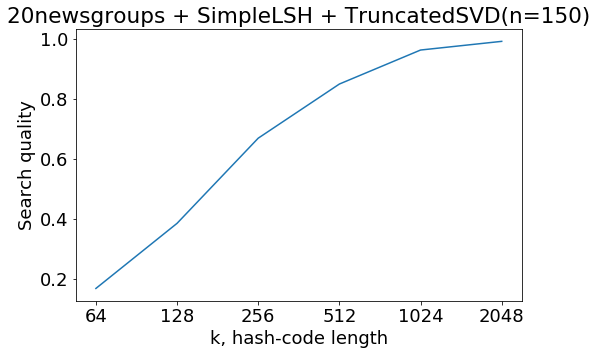

In [39]:
plt.figure(figsize=(8, 5))
plt.plot(np.array(perf)/3000)
plt.xticks(range(len(perf)), [2**k for k in range(6, 12)])
plt.xlabel("k, hash-code length")
plt.ylabel("Search quality")
plt.title("20newsgroups + SimpleLSH + TruncatedSVD(n=150)")

## Real W experiment

In [13]:
"""
Matrix in a form: a * [v_i], i=1...n
"""

class WeightMatrix:
    def __init__(self, dim):
        self.dim = n, d = dim
        self.a = 1.0
        self.snorm = 0.
        self.m = [ss.csr_matrix((1, d), dtype=np.float32) for _ in range(n)]

    def sparse_dot(self, ix: int, v: ss.csr_matrix):
        return sparse_sparse_dot(self.m[ix], v) * self.a

    def sparse_add(self, ix: int, v: ss.csr_matrix, s: float):
        old_ix_norm = np.dot(self.m[ix].data, self.m[ix].data)
        self.m[ix] += v * (s / self.a)
        new_ix_norm = np.dot(self.m[ix].data, self.m[ix].data)
        self.snorm += (new_ix_norm - old_ix_norm) * (self.a * self.a)
        return self.m[ix] * self.a

    def scale(self, s: float):
        if abs(s) < 1e-32:
            self.__init__(self.dim)
        else:
            self.a *= s
            self.snorm *= (s*s)

In [14]:
with open(os.path.join(out_dir, "W_LSHTC1.dump"), "rb") as fin:
    W_LSHTC1 = pickle.load(fin)

In [15]:
W = W_LSHTC1
W.a /= W.a * np.sqrt(max([np.dot(x.data, x.data) for x in W.m]))
Ws = ss.vstack(W.m) * W.a

In [16]:
Ws.shape

(12294, 409775)

#### PCA

In [ ]:
%%time 

pca = TruncatedSVD(n_components=1000)
Ws_pca = pca.fit_transform(Ws)
Ws = ss.csr_matrix(normalize(Ws_pca))

In [ ]:
%%time 

n_features = Ws.shape[1]
XXT = Ws.dot(Ws.T)

In [52]:
top2 = []
for w in tqdm(XXT):
    top2.append(sorted(enumerate(w.toarray()[0]), key = lambda x: x[1], reverse=True)[:3])


0it [00:00, ?it/s]
6it [00:00, 56.34it/s]
14it [00:00, 66.54it/s]
22it [00:00, 70.68it/s]
31it [00:00, 73.52it/s]
38it [00:00, 72.60it/s]
45it [00:00, 72.12it/s]
52it [00:00, 71.81it/s]
60it [00:00, 71.89it/s]
68it [00:00, 72.66it/s]
76it [00:01, 72.36it/s]
84it [00:01, 71.55it/s]
92it [00:01, 71.77it/s]
100it [00:01, 69.40it/s]
107it [00:01, 68.81it/s]
115it [00:01, 69.04it/s]
123it [00:01, 69.50it/s]
131it [00:01, 70.02it/s]
140it [00:01, 70.69it/s]
148it [00:02, 70.78it/s]
156it [00:02, 70.85it/s]
164it [00:02, 70.13it/s]
171it [00:02, 69.41it/s]
178it [00:02, 69.41it/s]
185it [00:02, 69.40it/s]
193it [00:02, 69.64it/s]
201it [00:02, 69.80it/s]
209it [00:03, 69.47it/s]
217it [00:03, 69.67it/s]
225it [00:03, 69.95it/s]
233it [00:03, 70.08it/s]
241it [00:03, 70.22it/s]
249it [00:03, 70.22it/s]
257it [00:03, 70.25it/s]
265it [00:03, 70.21it/s]
273it [00:03, 70.22it/s]
281it [00:04, 70.23it/s]
289it [00:04, 70.23it/s]
297it [00:04, 70.39it/s]
305it [00:04, 70.59it/s]
313it [00:04, 70.7

4136it [01:04, 63.80it/s]
4143it [01:04, 63.80it/s]
4150it [01:05, 63.81it/s]
4158it [01:05, 63.82it/s]
4165it [01:05, 63.83it/s]
4172it [01:05, 63.83it/s]
4179it [01:05, 63.84it/s]
4186it [01:05, 63.84it/s]
4193it [01:05, 63.85it/s]
4200it [01:05, 63.85it/s]
4207it [01:05, 63.86it/s]
4214it [01:05, 63.87it/s]
4221it [01:06, 63.87it/s]
4228it [01:06, 63.88it/s]
4235it [01:06, 63.89it/s]
4242it [01:06, 63.89it/s]
4249it [01:06, 63.88it/s]
4256it [01:06, 63.89it/s]
4263it [01:06, 63.90it/s]
4270it [01:06, 63.90it/s]
4277it [01:06, 63.91it/s]
4284it [01:07, 63.92it/s]
4291it [01:07, 63.93it/s]
4298it [01:07, 63.93it/s]
4305it [01:07, 63.94it/s]
4312it [01:07, 63.95it/s]
4319it [01:07, 63.95it/s]
4326it [01:07, 63.95it/s]
4333it [01:07, 63.95it/s]
4340it [01:07, 63.96it/s]
4347it [01:07, 63.96it/s]
4354it [01:08, 63.97it/s]
4361it [01:08, 63.98it/s]
4368it [01:08, 63.98it/s]
4375it [01:08, 63.99it/s]
4382it [01:08, 63.99it/s]
4389it [01:08, 64.00it/s]
4396it [01:08, 64.01it/s]
4403it [01:0

8111it [02:06, 64.32it/s]
8118it [02:06, 64.32it/s]
8125it [02:06, 64.30it/s]
8131it [02:06, 64.29it/s]
8137it [02:06, 64.29it/s]
8144it [02:06, 64.29it/s]
8151it [02:06, 64.29it/s]
8158it [02:06, 64.30it/s]
8165it [02:06, 64.30it/s]
8172it [02:07, 64.30it/s]
8179it [02:07, 64.31it/s]
8186it [02:07, 64.31it/s]
8193it [02:07, 64.31it/s]
8200it [02:07, 64.32it/s]
8207it [02:07, 64.32it/s]
8214it [02:07, 64.32it/s]
8221it [02:07, 64.32it/s]
8228it [02:07, 64.33it/s]
8235it [02:08, 64.33it/s]
8242it [02:08, 64.33it/s]
8249it [02:08, 64.34it/s]
8256it [02:08, 64.34it/s]
8263it [02:08, 64.33it/s]
8270it [02:08, 64.32it/s]
8277it [02:08, 64.33it/s]
8284it [02:08, 64.33it/s]
8291it [02:08, 64.33it/s]
8298it [02:08, 64.33it/s]
8305it [02:09, 64.33it/s]
8312it [02:09, 64.32it/s]
8319it [02:09, 64.31it/s]
8326it [02:09, 64.32it/s]
8333it [02:09, 64.32it/s]
8340it [02:09, 64.30it/s]
8346it [02:09, 64.29it/s]
8352it [02:09, 64.29it/s]
8359it [02:10, 64.29it/s]
8366it [02:10, 64.29it/s]
8373it [02:1

11733it [03:10, 61.57it/s]
11740it [03:10, 61.57it/s]
11747it [03:10, 61.57it/s]
11754it [03:10, 61.57it/s]
11761it [03:11, 61.57it/s]
11768it [03:11, 61.57it/s]
11775it [03:11, 61.57it/s]
11782it [03:11, 61.57it/s]
11789it [03:11, 61.57it/s]
11795it [03:11, 61.56it/s]
11801it [03:11, 61.56it/s]
11807it [03:11, 61.55it/s]
11813it [03:11, 61.54it/s]
11820it [03:12, 61.55it/s]
11827it [03:12, 61.55it/s]
11834it [03:12, 61.55it/s]
11841it [03:12, 61.55it/s]
11848it [03:12, 61.55it/s]
11855it [03:12, 61.55it/s]
11862it [03:12, 61.55it/s]
11869it [03:12, 61.55it/s]
11876it [03:12, 61.55it/s]
11883it [03:13, 61.55it/s]
11890it [03:13, 61.55it/s]
11897it [03:13, 61.56it/s]
11904it [03:13, 61.56it/s]
11911it [03:13, 61.56it/s]
11918it [03:13, 61.56it/s]
11925it [03:13, 61.56it/s]
11932it [03:13, 61.56it/s]
11939it [03:13, 61.57it/s]
11946it [03:14, 61.57it/s]
11953it [03:14, 61.57it/s]
11960it [03:14, 61.57it/s]
11967it [03:14, 61.57it/s]
11974it [03:14, 61.58it/s]
11981it [03:14, 61.58it/s]
1

In [55]:
perf_W = []

In [57]:
for k in tqdm([2**t for t in range(5, 13)]):
    a = np.random.randn(k, n_features + 1)
    Ws_lsh = np.array([simple_lsh(v, k, a) for v in Ws])
    top20_lsh = []
    for w in Ws_lsh:
        top20_lsh.append(sorted(enumerate([sp.spatial.distance.hamming(w, v) for v in Ws_lsh]), key = lambda x: x[1])[:20])
    s = 0
    for lsh_result, exact_result in zip(top20_lsh, top2):
        if {j[0] for j in exact_result}.issubset({j[0] for j in lsh_result}):
            s += 1
    perf_W.append(s)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [51:08<5:57:58, 3068.33s/it]

 25%|██▌       | 2/8 [1:42:23<5:07:09, 3071.61s/it]

 38%|███▊      | 3/8 [2:33:23<4:15:39, 3067.98s/it]

 50%|█████     | 4/8 [3:25:28<3:25:28, 3082.08s/it]

 62%|██████▎   | 5/8 [4:23:44<2:38:14, 3164.90s/it]

 75%|███████▌  | 6/8 [5:29:14<1:49:44, 3292.47s/it]

 88%|████████▊ | 7/8 [6:41:25<57:20, 3440.81s/it]  

100%|██████████| 8/8 [8:10:25<00:00, 3678.14s/it]



In [60]:
len(Ws_lsh)

12294

Text(0.5,1,'LSHTC1 + SimpleLSH(top-20) + TruncatedSVD(n=150)')

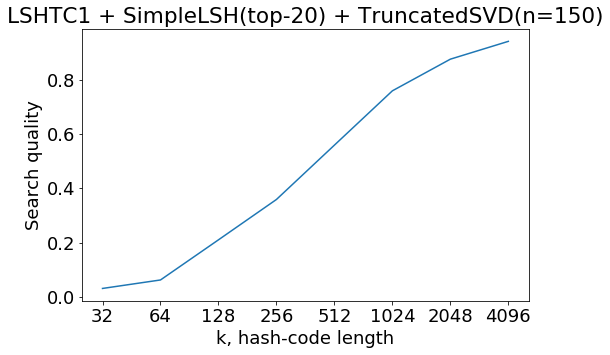

In [64]:
plt.figure(figsize=(8, 5))
plt.plot(np.array(perf_W)/len(Ws_lsh))
plt.xticks(range(len(perf_W)), [2**k for k in range(5, 13)])
plt.xlabel("k, hash-code length")
plt.ylabel("Search quality")
plt.title("LSHTC1 + SimpleLSH(top-20) + TruncatedSVD(n=150)")